### Optimal Transport

#### a. VoxCeleb1



In [1]:
import torch
import numpy as np
import kaldiio
from kaldiio import ReadHelper
import seaborn as sns
import os

import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

from matplotlib.collections import PolyCollection
from scipy.interpolate import make_interp_spline
from scipy import stats
import pandas as pd

In [2]:
script_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/local/project/lstm_speaker_verification'

kwargs = {'num_workers': 8, 'pin_memory': False}
# /home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/logits/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456

solors = ['#fff7f5', '#fff3f0', '#ffefeb', '#ffebe6', '#fee7e0', '#fee3db', '#fedfd6', '#fedcd1', '#fed8cc', '#fed4c7', '#fed0c2', '#feccbd', '#fec8b8', '#fec4b3', '#fdc0ad', '#fdbca8', '#fdb8a3', '#fdb49e', '#fdb099', '#fdac94', '#fda88f', '#fda48a', '#fda085', '#fd9d80', '#fc997a', '#fc9575', '#fc9170', '#fc8d6b', '#fc8966', '#fc8561', '#fc815c', '#fc7d57', '#fc7952', '#fc754d', '#fb7147', '#fb6d42', '#fb693d', '#fb6538', '#fb6133', '#fb5d2e', '#fb5a29', '#fb5624', '#fb521f', '#fb4e19', '#fa4a14', '#fa460f', '#fa420a', '#fa3e05', '#fa3a00', '#f53900', '#f03800', '#eb3700', '#e63500', '#e13400', '#dc3300', '#d73200', '#d23100', '#cd3000', '#c82e00', '#c32d00', '#be2c00', '#b92b00', '#b42a00', '#af2900', '#aa2700', '#a52600', '#a02500', '#9b2400', '#962300', '#912200', '#8c2000', '#871f00', '#821e00', '#7d1d00', '#781c00', '#731b00', '#6e1a00', '#691800', '#641700', '#5f1600', '#5a1500', '#551400', '#501300', '#4b1100', '#461000', '#410f00', '#3c0e00', '#370d00']

solors2 = ['#f7f9f9', '#f3f6f5', '#eef3f2', '#eaf0ef', '#e6edec', '#e2e9e9', '#dee6e5', '#dae3e2', '#d6e0df', '#d1dddc', '#cddad9', '#c9d7d5', '#c5d4d2', '#c1d1cf', '#bdcecc', '#b9cbc9', '#b4c8c5', '#b0c4c2', '#acc1bf', '#a8bebc', '#a4bbb9', '#a0b8b5', '#9cb5b2', '#98b2af', '#93afac', '#8faca9', '#8ba9a5', '#87a6a2', '#83a39f', '#7fa09c', '#7b9c99', '#769995', '#729692', '#6e938f', '#6a908c', '#668d89', '#628a85', '#5e8782', '#59847f', '#55817c', '#517e79', '#4d7b75', '#497772', '#45746f', '#41716c', '#3c6e69', '#386b65', '#346862', '#30655f', '#2f635d', '#2e615b', '#2d5f59', '#2c5d57', '#2b5b56', '#2a5954', '#295752', '#285550', '#27534e', '#26514c', '#254f4a', '#244d48', '#244b46', '#234944', '#224743', '#214541', '#20433f', '#1f413d', '#1e3f3b', '#1d3d39', '#1c3b37', '#1b3935', '#1a3733', '#193531', '#183330', '#17302e', '#162e2c', '#152c2a', '#142a28', '#132826', '#122624', '#112422', '#102220', '#0f201e', '#0e1e1d', '#0d1c1b', '#0c1a19', '#0c1817', '#0b1615']

genres = ['advertisement', 'drama', 'entertainment', 'interview', 'live_broadcast', 'movie', 'play', 'recitation', 'singing', 'speech', 'vlog']

In [3]:
def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]

def kurtoses(target_score):
    target_score = torch.tensor(target_score)

    diffs = target_score - target_score.mean()
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    z_scores = diffs / std

    kurtoses = torch.mean(torch.pow(z_scores, 4.0)) - 3.0
    
    return kurtoses

In [4]:
vox1_dir = 'ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456'

cnc1_dir = 'ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_core/percent0.5_random/123456'

spk2idx = {}

for this_dir in [vox1_dir, cnc1_dir]:
    idx_file = script_dir + '/' + 'Data/logits/' + this_dir+ '/idx2spk'
    with open(idx_file, 'r') as f:
        for l in f.readlines():
            idx, spk= l.split()
            spk2idx[spk] = int(idx)

In [5]:
# plt.figure(figsize=(12, 4))
# plt.title("The Duration of Total Utterances Per Speaker", fontsize=18)
set_names = ['vox1', 'cnceleb']
# set_names = ['cnceleb']
spk2num_frames = {}
uid2spk = {}

for s in set_names:    
    utt2num_frames = {}
    with open(lstm_dir + '/data/%s/klfb/dev_fb40/utt2num_frames' % (s), 'r') as f:
        for l in f.readlines():
            uid, num_frames = l.split()
            utt2num_frames[uid] = int(num_frames)

    with open(lstm_dir + '/data/%s/klfb/dev_fb40/spk2utt'% (s), 'r') as f:
        for l in f.readlines():
            sid_uids = l.split()
            for uid in sid_uids[1:]:
                uid2spk[uid] = sid_uids[0]
                
            spk2num_frames[sid_uids[0]] = 0
            for uid in sid_uids[1:]:
                spk2num_frames[sid_uids[0]] += utt2num_frames[uid]

In [6]:
epochs = [i for i in range(1, 47)]
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
target_score_dict = {}
for i,epoch in enumerate(epochs):
    target_dict = {}
    xvector_path = 'Data/logits/' + vox1_dir+ '/vox1_dev_%d_fix/test/sim.ark.gz'%(epoch)
    with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]
            # print(idx)
            if idx in target_dict:
                target_dict[idx].append(numpy_array[idx])
            else:
                target_dict[idx] = [numpy_array[idx]]
    
    target_score = []
    for idx in target_dict:
        target_score.extend(target_dict[idx])
    
    target_score_dict[epoch] = target_score

In [7]:
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
target_score_dict2 = {}
for i,epoch in enumerate(epochs):
    target_dict = {}
    xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
    with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]
            # print(idx)
            if idx in target_dict:
                target_dict[idx].append(numpy_array[idx])
            else:
                target_dict[idx] = [numpy_array[idx]]
    
    target_score = []
    for idx in target_dict:
        target_score.extend(target_dict[idx])
    
    target_score_dict2[epoch] = target_score

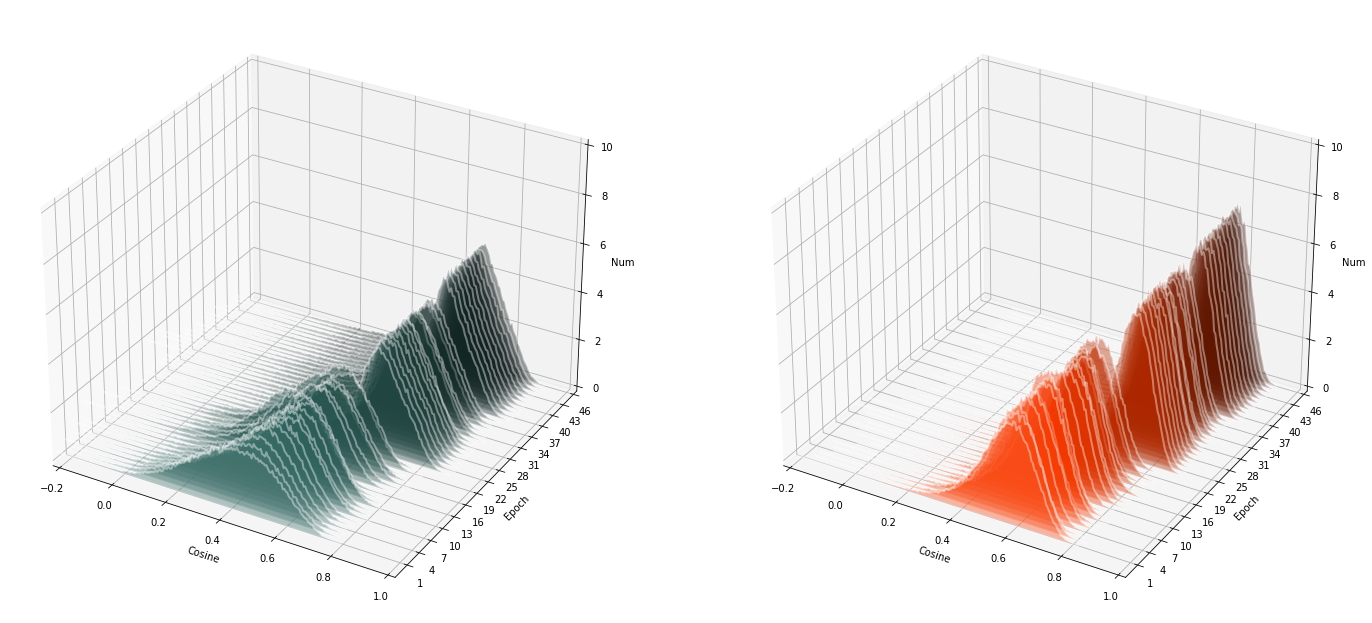

In [8]:
fig = plt.figure(figsize=(24, 12))

ax = fig.add_subplot(121, projection='3d')
# ax = plt.subplot(121).add_subplot(projection='3d')
# Make verts a list such that verts[i] is a list of (x, y) pairs defining polygon i.
# The ith polygon will appear on the plane y = zs[i]
zs = epochs
verts = []
for i, epoch in enumerate(epochs):
    target_score = target_score_dict2[epoch]
    hists, edgs = np.histogram(target_score, bins=200, density=True)
    # plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
    # plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists

    verts.append(polygon_under_graph(xs, ys))

poly2 = PolyCollection(verts, facecolors=solors2[-len(verts):], edgecolors=("white",), alpha=.4, linewidths=2.0)
ax.add_collection3d(poly2, zs=[i-1 for i in zs], zdir='y')
ax.set_xlabel('Cosine')
ax.set_ylabel('Epoch')
ax.set_zlabel('Num')
ax.set_yticks(np.arange(1, 47, 3))
ax.set_xlim(-0.2, 1)
ax.set_ylim(-1, 46)
ax.set_zlim(0, 10)

ax = fig.add_subplot(122, projection='3d')
verts = []
for i, epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    hists, edgs = np.histogram(target_score, bins=200, density=True)
    # plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
    # plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists

    verts.append(polygon_under_graph(xs, ys))

poly = PolyCollection(verts, facecolors=solors[-len(verts):], edgecolors=("white",), alpha=.4, linewidths=2.0)
ax.add_collection3d(poly, zs=[i-1 for i in zs], zdir='y')

ax.set_xlabel('Cosine')
ax.set_ylabel('Epoch')
ax.set_zlabel('Num')

ax.set_yticks(np.arange(1, 47, 3))
ax.set_xlim(-0.2, 1)
ax.set_ylim(-1, 46)
ax.set_zlim(0, 10)

plt.show()

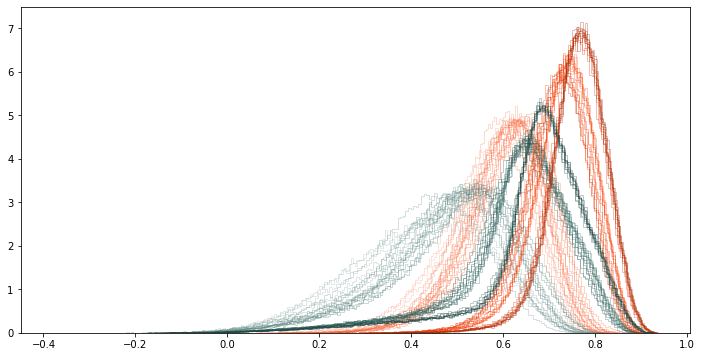

In [9]:
plt.figure(figsize=(12,6))
# fig, (ax1, ax2) = plt.subplots(2, 1)
for i,epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    # plt.subplot(4, 1, int(i//5+1))
    _ = plt.hist(target_score, bins=200, histtype='step', color=solors[i+20], density=True, alpha=0.3)    
    target_score = target_score_dict2[epoch]
    _ = plt.hist(target_score, bins=200, histtype='step', color=solors2[i+20], density=True, alpha=0.3)
# ax2.invert_yaxis()

In [82]:
centers = []
prototype_sims = []
prototype_l2s = []

for e in range(1, 46):
    
    ckp_path = script_dir + '/Data/checkpoint/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456/checkpoint_%d.pth' % e
    
    if os.path.exists(ckp_path):
        ckp = torch.load(ckp_path)
        model_dict = ckp['state_dict']
        center = model_dict['classifier.W']
        
        centers.append(center)
        center /= center.norm(dim=0, p=2)
        prototype_sim = center.T.matmul(center)
        
        prototype_l2s.append((center[0]-center[1:]).norm(dim=0, p=2).cpu().numpy())
        prototype_sims.append(prototype_sim[0, 1:].cpu().numpy())
        # print(center.norm(dim=0, p=2))
        
prototype_sims = np.array(prototype_sims)
prototype_l2s = np.array(prototype_l2s)

center_shift = []
for i in range(1, 45):
    center_shift.append(torch.cosine_similarity(centers[i], centers[i-1], dim=0).cpu().numpy())
center_shift = np.array(center_shift)

(0.0, 180.0)

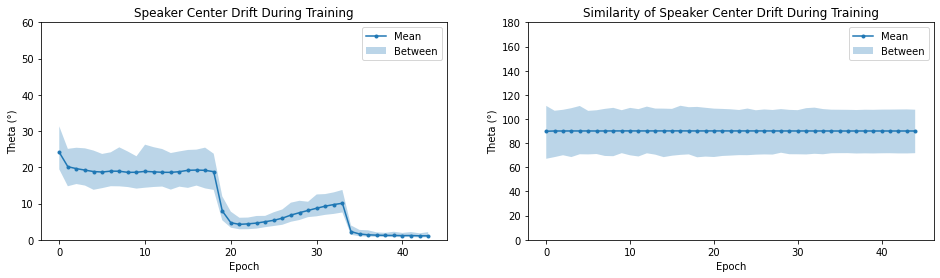

In [115]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.title('Speaker Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(center_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(center_shift.max(axis=1))*180/np.pi, np.arccos(center_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
# plt.plot(np.arccos(center_shift.min(axis=1))*180/np.pi, marker='.')
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 60)
# 和 variational prototype learning for deep face recognition 中的drift不相同，
# 在该论文中一个epoch后的prototype的drift在一个很小的范围内


plt.subplot(1,2,2)
plt.title('Similarity of Speaker Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(prototype_sims.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(45), np.arccos(prototype_sims.max(axis=1))*180/np.pi, np.arccos(prototype_sims.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 180)

In [97]:
prototype_centers = []

for e in range(1, 46):
    spk2vectors = {} 
    prototype_center = []
    xvetor_path = script_dir + '/Data/logits/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456/vox1_dev_%d_fix/test/xvectors.ark' % e
    
    with ReadHelper('ark:%s'%( xvetor_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]

            if idx in spk2vectors:
                spk2vectors[idx].append(numpy_array)
            else:
                spk2vectors[idx] = [numpy_array]

    spks = list(spk2vectors.keys())
    spks.sort()
    
    for idx in spks:
        spk_mean = np.mean(spk2vectors[idx], axis=0)
        prototype_center.append(spk_mean)
        
    prototype_centers.append(prototype_center)

In [111]:
prototype_shift = []
epochs_cos = []
for i, prototype in enumerate(prototype_centers):
    np_prototype = torch.tensor(np.array(prototype)).cuda()
    
    if i+1 < len(prototype_centers):
        prototype_shift.append(torch.cosine_similarity(np_prototype, torch.tensor(np.array(prototype_centers[i+1])).cuda(), dim=1).cpu().numpy())
    
    center = centers[i].clone().T
    coss = torch.cosine_similarity(np_prototype, center)
    epochs_cos.append(coss.cpu().numpy())
    
prototype_shift = np.array(prototype_shift)
epochs_cos = np.array(epochs_cos)

Text(0.5, 0, 'Epoch')

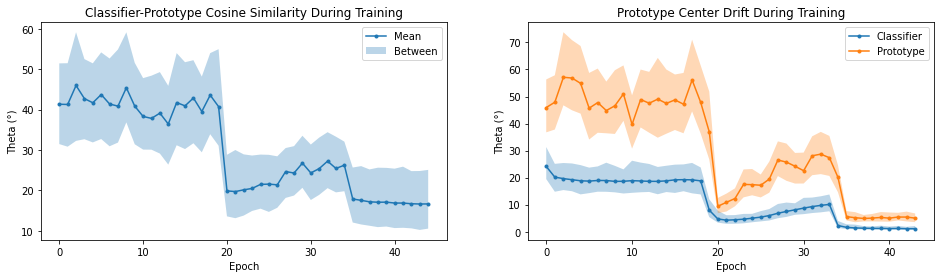

In [122]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.title('Classifier-Prototype Cosine Similarity During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(epochs_cos.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(45), np.arccos(epochs_cos.max(axis=1))*180/np.pi, np.arccos(epochs_cos.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
# plt.plot(np.arccos(center_shift.min(axis=1))*180/np.pi, marker='.')
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
# plt.ylim(0, 80)
# 和 variational prototype learning for deep face recognition 中的drift不相同，
# 在该论文中一个epoch后的prototype的drift在一个很小的范围内


plt.subplot(1,2,2)
plt.title('Prototype Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(center_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(center_shift.max(axis=1))*180/np.pi, np.arccos(center_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.plot(np.arccos(prototype_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(prototype_shift.max(axis=1))*180/np.pi, np.arccos(prototype_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Classifier', 'Prototype'])
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
# plt.ylim(0, 60)

In [175]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

cen_proto = np.concatenate([np.array(centers[-1].cpu().T), np.array(prototype_centers[-1])], axis=0)
embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(cen_proto)

# embedded = PCA(n_components=2).fit_transform(cen_proto)

In [169]:
c_centers = []
c_prototype_sims = []
c_prototype_l2s = []

for e in range(1, 46):
    
    ckp_path = script_dir + '/Data/checkpoint/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_core/percent0.5_random/123456/checkpoint_%d.pth' % e
    
    if os.path.exists(ckp_path):
        ckp = torch.load(ckp_path)
        model_dict = ckp['state_dict']
        center = model_dict['classifier.W']
        
        c_centers.append(center)
        center /= center.norm(dim=0, p=2)
        prototype_sim = center.T.matmul(center)
        
        c_prototype_l2s.append((center[0]-center[1:]).norm(dim=0, p=2).cpu().numpy())
        c_prototype_sims.append(prototype_sim[0, 1:].cpu().numpy())
        # print(center.norm(dim=0, p=2))
        
c_prototype_sims = np.array(c_prototype_sims)
c_prototype_l2s = np.array(c_prototype_l2s)

c_center_shift = []
for i in range(1, 45):
    c_center_shift.append(torch.cosine_similarity(c_centers[i], c_centers[i-1], dim=0).cpu().numpy())
c_center_shift = np.array(c_center_shift)

(0.0, 180.0)

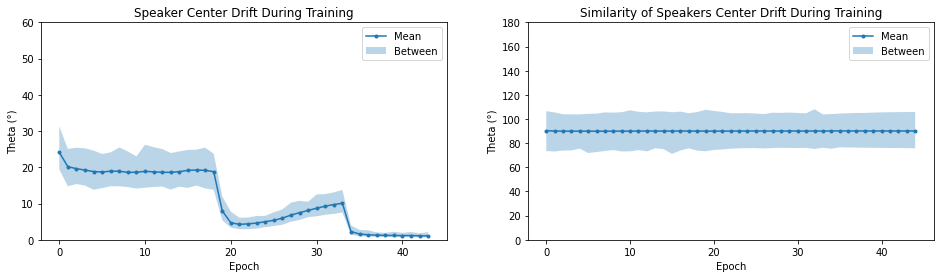

In [157]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.title('Speaker Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(c_center_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(c_center_shift.max(axis=1))*180/np.pi, np.arccos(c_center_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
# plt.plot(np.arccos(center_shift.min(axis=1))*180/np.pi, marker='.')
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 60)
# 和 variational prototype learning for deep face recognition 中的drift不相同，
# 在该论文中一个epoch后的prototype的drift在一个很小的范围内


plt.subplot(1,2,2)
plt.title('Similarity of Speakers Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(c_prototype_sims.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(45), np.arccos(c_prototype_sims.max(axis=1))*180/np.pi, np.arccos(c_prototype_sims.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 180)

In [158]:
c_prototype_centers = []

for e in range(1, 46):
    spk2vectors = {} 
    prototype_center = []
    xvetor_path = script_dir + '/Data/logits/ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_core/percent0.5_random/123456/cnceleb_dev_%d_fix/test/xvectors.ark' % e
    
    with ReadHelper('ark:%s'%( xvetor_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]

            if idx in spk2vectors:
                spk2vectors[idx].append(numpy_array)
            else:
                spk2vectors[idx] = [numpy_array]

    spks = list(spk2vectors.keys())
    spks.sort()
    
    for idx in spks:
        spk_mean = np.mean(spk2vectors[idx], axis=0)
        prototype_center.append(spk_mean)
        
    c_prototype_centers.append(prototype_center)

In [161]:
c_prototype_shift = []
c_epochs_cos = []
for i, prototype in enumerate(c_prototype_centers):
    np_prototype = torch.tensor(np.array(prototype)).cuda()
    
    if i+1 < len(prototype_centers):
        c_prototype_shift.append(torch.cosine_similarity(np_prototype, torch.tensor(np.array(c_prototype_centers[i+1])).cuda(), dim=1).cpu().numpy())
    
    center = c_centers[i].clone().T
    coss = torch.cosine_similarity(np_prototype, center)
    c_epochs_cos.append(coss.cpu().numpy())
    
c_prototype_shift = np.array(c_prototype_shift)
c_epochs_cos = np.array(c_epochs_cos)

In [ ]:
c_cen_proto = np.concatenate([np.array(c_centers[-1].cpu().T), np.array(c_prototype_centers[-1])], axis=0)
c_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(c_cen_proto)

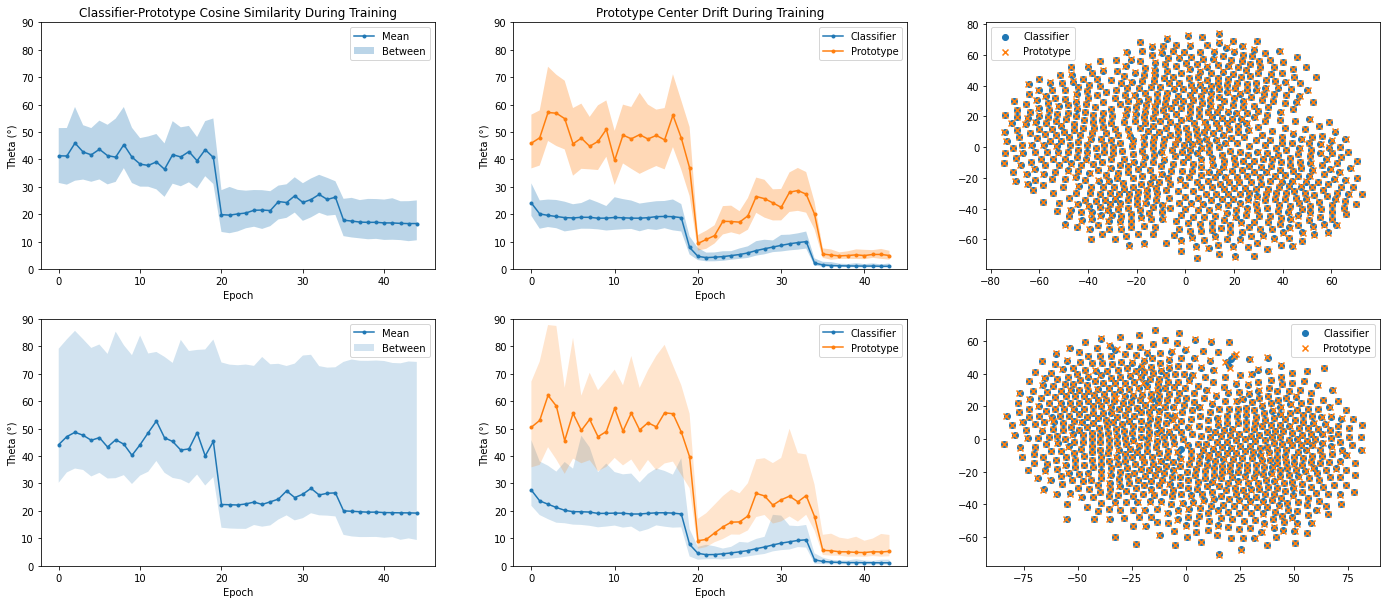

In [178]:
plt.figure(figsize=(24, 10))

plt.subplot(2,3,1)
plt.title('Classifier-Prototype Cosine Similarity During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(epochs_cos.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(45), np.arccos(epochs_cos.max(axis=1))*180/np.pi, np.arccos(epochs_cos.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Mean', 'Between'])
# plt.plot(np.arccos(center_shift.min(axis=1))*180/np.pi, marker='.')
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 90)
# plt.ylim(0, 80)
# 和 variational prototype learning for deep face recognition 中的drift不相同，
# 在该论文中一个epoch后的prototype的drift在一个很小的范围内


plt.subplot(2,3,2)
plt.title('Prototype Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(center_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(center_shift.max(axis=1))*180/np.pi, np.arccos(center_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.plot(np.arccos(prototype_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(prototype_shift.max(axis=1))*180/np.pi, np.arccos(prototype_shift.min(axis=1))*180/np.pi, alpha=0.3)

plt.legend(['Classifier', 'Prototype'])
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 90)

plt.subplot(2,3,4)
# plt.title('Classifier-Prototype Cosine Similarity During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(c_epochs_cos.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(45), np.arccos(c_epochs_cos.max(axis=1))*180/np.pi, np.arccos(c_epochs_cos.min(axis=1))*180/np.pi, alpha=0.2)

plt.legend(['Mean', 'Between'])
# plt.plot(np.arccos(center_shift.min(axis=1))*180/np.pi, marker='.')
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 90)
# plt.ylim(0, 80)

plt.subplot(2,3,5)
# plt.title('Speaker Center Drift During Training')
# center_shift.shape
# plt.plot(np.arccos(center_shift.max(axis=1))*180/np.pi, marker='.')
plt.plot(np.arccos(c_center_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(c_center_shift.max(axis=1))*180/np.pi, np.arccos(c_center_shift.min(axis=1))*180/np.pi, alpha=0.2)

plt.plot(np.arccos(c_prototype_shift.mean(axis=1))*180/np.pi, marker='.')
plt.fill_between(np.arange(44), np.arccos(c_prototype_shift.max(axis=1))*180/np.pi, np.arccos(c_prototype_shift.min(axis=1))*180/np.pi, alpha=0.2)

plt.legend(['Classifier', 'Prototype'])
plt.ylabel('Theta (°)')
plt.xlabel('Epoch')
plt.ylim(0, 90)

plt.subplot(2,3,3)

plt.scatter(embedded[:797, 0], embedded[:797, 1], marker='o')
plt.scatter(embedded[797:, 0], embedded[797:, 1], marker='x')
plt.legend(['Classifier', 'Prototype'])

plt.subplot(2,3,6)
plt.scatter(c_embedded[:797, 0], c_embedded[:797, 1], marker='o')
plt.scatter(c_embedded[797:, 0], c_embedded[797:, 1], marker='x')
plt.legend(['Classifier', 'Prototype'])

# prototype and classifier centers is perfectly matched for vox1.

##### 图例注释
图的第一行为voxceleb数据集，第二行为cnceleb数据集。为了对照，其中voxceleb数据集将说话人数目减少到了797，和cnceleb保持一致。
第一列为随着epoch增长说话人的平均类中心和分类器类中心的距离变化，第二列为平均类中心和分类器类中心训练过程中的漂移优化情况，第三列为平均类中心和分类器类中心使用t-sne投射到二维空间的结果。

#### 结论

在网络优化过程中，两个数据集的*相似点*是：

1. 网络没有把样本的平均类中心当作分类器中心，且网络分类器中心训练中的漂移情况要比平均类中心更稳定,但两者的变化趋势相似；

2. 在第一次（在第20个epoch左右）学习率下降时，网络分类中心和平均类中心的优化导致的漂移距离会突然下降，然后再次上升。这里和模型在测试数据集的表现极其相似，当漂移距离上升后，模型的错误率也会某种程度上升。在模型训练的后期，学习率再次下降时优化导致的漂移距离会再次下降。

3. 网络最终收敛的两种类中心在使用t-sne投射的二维空间下，有明显的重合。

在网络优化过程中，两个数据集的*差异点*是：

1. cnceleb数据集的相同类（说话人）的平均类中心和分类器中心的距离的最大值远超voxceleb，即使在网络收敛的后期，也存在类别的平均类中心和分类器中心相差巨大。

2. cnceleb数据集较voxceleb数据集，网络训练优化过程中的两种类别中心的漂移明显更严重，在更大区间内漂移 / 或者是类别间的差异更明显。

3. cnceleb数据集下收敛的类中心有没有匹配的类，而voxceleb的所有类中心完美匹配。

In [125]:
1-np.cos(30/180*np.pi)

0.1339745962155613

In [193]:
for emb in [embedded, c_embedded]:
    center_sim = np.linalg.norm(emb[:797] - emb[797:], 2, axis=1)
    sort_idx = np.argsort(center_sim)
    center_sim_mean = center_sim.mean()
    center_sim_std = center_sim.std()

    print(center_sim[sort_idx[-10:]])

[0.19433196 0.19496197 0.19508772 0.19899552 0.19957644 0.2004773
 0.20076406 0.21030219 0.21287039 0.22514635]
[ 0.72114205  0.73383915  0.8242658   0.8639134   0.8785762   0.9877917
  1.0205773   1.024916    4.272918   43.333897  ]


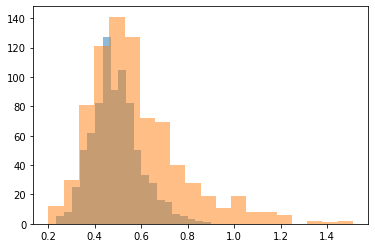

In [196]:
for emb in [cen_proto, c_cen_proto]:
    center_sim = np.linalg.norm(emb[:797] - emb[797:], 2, axis=1)
    sort_idx = np.argsort(center_sim)
    center_sim_mean = center_sim.mean()
    center_sim_std = center_sim.std()
    
    print
    # print(center_sim[sort_idx[-10:]])
    plt.hist(center_sim, bins=20, alpha=0.5)

In [10]:
# epochs = [i for i in range(1, 47)]
epoch = 46
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
v_target_scores = []
v_nontarget_scores = []
xvector_path = 'Data/logits/' + vox1_dir+ '/vox1_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        idx = spk2idx[spk]
        v_target_scores.append(numpy_array[idx])
        v_nontarget_scores.extend(np.delete(numpy_array, idx))

In [ ]:
print('vox1: ' , float(kurtoses(v_target_scores)))

In [ ]:
a = np.arange(12)
print(a)
print(np.delete(a, 0))

In [12]:
# epochs = [i for i in range(1, 47)]
epoch = 46
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
genre_target_score_dict = {}
genre_nontarget_score_dict = {}

for g in genres:
    genre_target_score_dict[g] = []
    genre_nontarget_score_dict[g] = []
    
# target_dict = {}
xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        g = key.split('-')[1]
        idx = spk2idx[spk]
        # print(idx)
        genre_target_score_dict[g].append(numpy_array[idx])
        genre_nontarget_score_dict[g].extend(np.delete(numpy_array, idx))

In [13]:
# fig, (ax1, ax2) = plt.subplots(2, 1)
c_target_score = []
c_nontarget_score = []

for i,g in enumerate(genres):
    c_target_score.extend(genre_target_score_dict[g])
    c_nontarget_score.extend(genre_nontarget_score_dict[g])

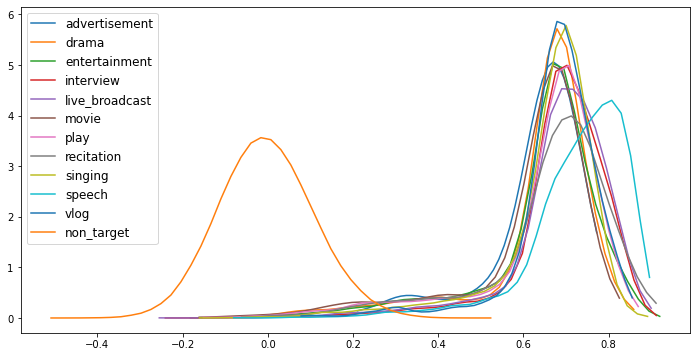

In [14]:
plt.figure(figsize=(12,6))
# fig, (ax1, ax2) = plt.subplots(2, 1)
legends = []
for i,g in enumerate(genres):
    target_score = genre_target_score_dict[g]
    legends.append(g)
    # plt.subplot(4, 1, int(i//5+1))
    # _ = plt.hist(target_score, bins=50, histtype='step', density=True, alpha=1) 
    hists, edgs = np.histogram(target_score, bins=45, density=True)
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists
    ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
    plt.plot(xs, ys)
    
target_score = genre_nontarget_score_dict[g]
legends.append('non_target')

hists, edgs = np.histogram(target_score, bins=45, density=True)
xs, ys= (edgs[:-1]+edgs[1:])/2, hists
ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
plt.plot(xs, ys)
    
# ax2.invert_yaxis()
plt.legend(legends, fontsize=12)

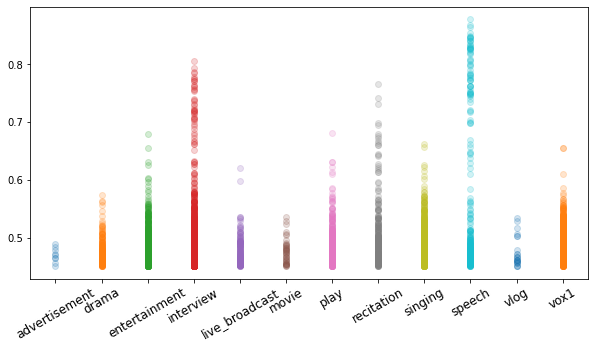

In [24]:
plt.figure(figsize=(10,5))

numoftimes = 4
c_mean = np.mean(c_nontarget_score)
c_std = np.std(c_nontarget_score)

over_scores_g = {}
for i,g in enumerate(genres):
    target_score = np.array(genre_nontarget_score_dict[g])
    over_scores = target_score[np.where(target_score>(c_mean+4*c_std))[0]]
    
    # if len(over_scores)>0:
    #     print("{:>14}: {:.4f}".format(g, (len(over_scores)/len(target_score))*100))
    over_scores_g[g] = over_scores

v_mean = np.mean(v_nontarget_scores)
v_std = np.std(v_nontarget_scores)

target_score = np.array(v_nontarget_scores)
over_scores = target_score[np.where(target_score>(v_mean+4*v_std))[0]]
over_scores_g['vox1'] = over_scores

for g in over_scores_g:
    plt.scatter([g]*len(over_scores_g[g]), over_scores_g[g], alpha=0.2)
    
_ = plt.xticks(rotation=30, fontsize=12)
# sns.histplot(over_scores_g, common_norm=False)
# print("{:>14}: {:.4f}".format('vox1', (len(over_scores)/len(target_score))*100))
# plt.legend(legends, fontsize=12)

/tmp/ipykernel_1957343/1410544181.py:17: RuntimeWarning: divide by zero encountered in log
  partition = np.log(partition)


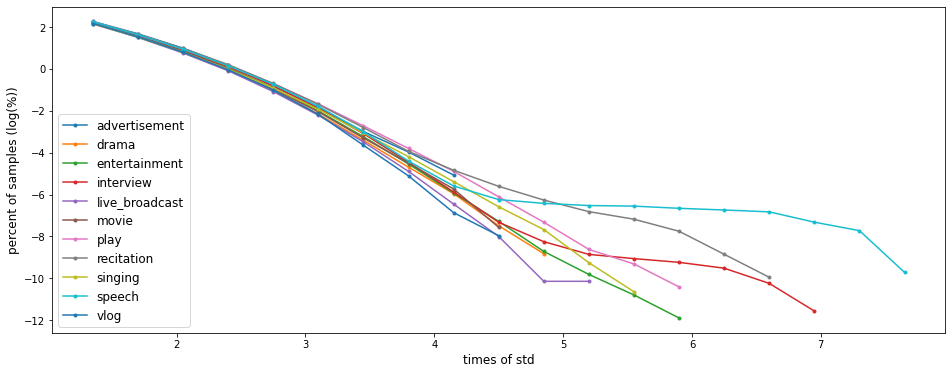

In [20]:
plt.figure(figsize=(16, 6))

ys_c = {}
for i,g in enumerate(genres):
    ys_c[g] = []
    
xs = []
for p in range(1, 21):
    numoftimes = 1 + 7 * p/20
    xs.append(numoftimes)
    
    for i,g in enumerate(genres):
        target_score = np.array(genre_nontarget_score_dict[g])
        over_scores = target_score[np.where(target_score>(c_mean+numoftimes*c_std))[0]]

        partition = len(over_scores)/len(target_score)*100
        partition = np.log(partition)
        
        ys_c[g].append(partition)

for i,g in enumerate(genres):
    plt.plot(xs, ys_c[g], marker='.')
    
plt.ylabel('percent of samples (log(%))', fontsize=12)
plt.xlabel('times of std', fontsize=12)

# print("{:>14}: {:.4f}".format('vox1', (len(over_scores)/len(target_score))*100))
plt.legend(genres, fontsize=12)

In [25]:
numoftimes = 4
c_mean = np.mean(c_nontarget_score)
c_std = np.std(c_nontarget_score)
v_mean = np.mean(v_nontarget_scores)
v_std = np.std(v_nontarget_scores)
v_nontarget_score = np.array(v_nontarget_scores)
c_nontarget_score = np.array(c_nontarget_score)

xs = genres.copy()
xs.append('vox1')

/tmp/ipykernel_1961219/431816326.py:19: RuntimeWarning: divide by zero encountered in log
  partition = np.log(partition)
/tmp/ipykernel_1961219/431816326.py:13: RuntimeWarning: divide by zero encountered in log
  partition = np.log(partition)


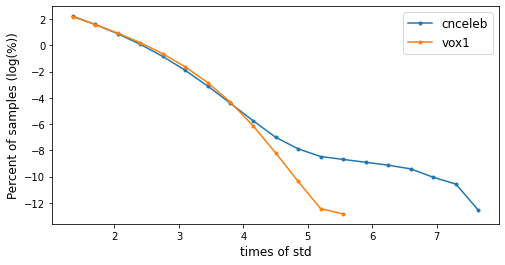

In [27]:
# 数据集比较
plt.figure(figsize=(8,4))

ys_c = []
ys_v = []
xs = []
for p in range(1, 21):
    numoftimes = 1 + 7 * p/20
    xs.append(numoftimes)
    
    over_scores = c_nontarget_score[np.where(c_nontarget_score>(c_mean+numoftimes*c_std))[0]]
    partition = len(over_scores)/len(c_nontarget_score)*100
    partition = np.log(partition)
    ys_c.append(partition)
    # plt.plot(xs, ys)
    
    over_scores = v_nontarget_score[np.where(v_nontarget_score>(v_mean+numoftimes*v_std))[0]]
    partition = len(over_scores)/len(v_nontarget_score)*100
    partition = np.log(partition)
    ys_v.append(partition)
    # ys.append(np.mean(over_scores))
    # plt.plot(xs, ys)
    
plt.plot(xs, ys_c, marker='.')
plt.plot(xs, ys_v, marker='.')
plt.ylabel('Percent of samples (log(%))', fontsize=12)
plt.xlabel('times of std', fontsize=12)

plt.legend(['cnceleb', 'vox1'], fontsize=12)
# 在cnceleb中，相较于voxceleb，非目标类的相似度在高于整体非目标类相似度 mean+4*std 的相似度区间内，有更多样本分布
# heavy-tailed !

In [23]:
c_mean+8*c_std

0.9034415927017108

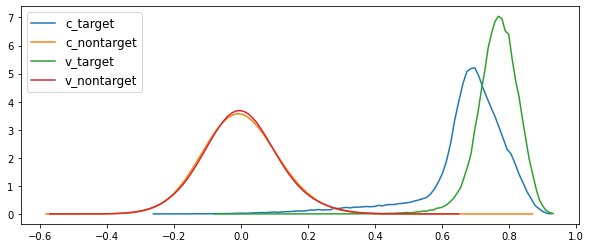

In [29]:
plt.figure(figsize=(10, 4))

for scores in [c_target_score, c_nontarget_score, v_target_scores, v_nontarget_scores]:
    hists, edgs = np.histogram(scores, bins=100, density=True)
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists
    # ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
    plt.plot(xs, ys)

# ax2.invert_yaxis()
plt.legend(['c_target', 'c_nontarget', 'v_target', 'v_nontarget'], fontsize=12)

In [26]:
print('cnc1: {:>.4f}'.format(kurtoses(c_target_score)))
print('vox1: {:>.4f}'.format(kurtoses(v_target_scores)))

cnc1: 5.6059
vox1: 3.9821


In [27]:
for i,g in enumerate(genres):
    target_score = genre_target_score_dict[g]
    print('{:.4f}, '.format(np.mean(target_score)), end='')

0.6318, 0.6312, 0.6409, 0.6850, 0.6853, 0.6124, 0.6429, 0.6582, 0.6544, 0.7296, 0.6761, 

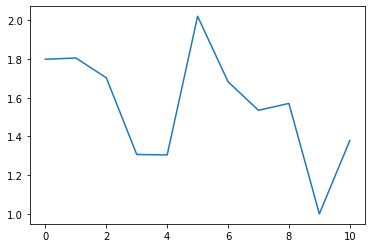

In [28]:
domain_weight = np.array([0.6318, 0.6312, 0.6409, 0.6850, 0.6853, 0.6124, 0.6429, 0.6582, 0.6544, 0.7296, 0.6761])
domain_weight = np.exp(6*(-domain_weight+0.75))
domain_weight /= domain_weight.min()

plt.plot(domain_weight)

In [30]:
epoch = 46
spk2genres = {}

xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        g = key.split('-')[1]
        
        idx = spk2idx[spk]
        # print(idx)
        if spk in spk2genres:
            spk2genres[spk].add(g)
        else:
            spk2genres[spk] = set([g])

In [31]:
numofg2spk = {}
for i in range(1, 12):
    numofg2spk[i] = []
    
for spk in spk2genres:
    numofg2spk[len(spk2genres[spk])].append(spk)

In [32]:
numofg2spk[6]

['id00406']

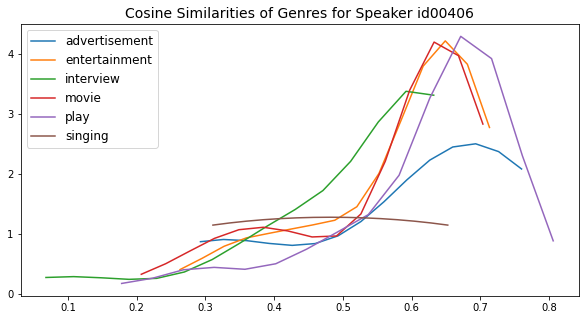

In [32]:
epoch = 46
this_spk = 'id00406'#'id00491'
skp_score_dict = {}
for g in genres:
    skp_score_dict[g] = []

xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        if spk == this_spk:
            g = key.split('-')[1]
            idx = spk2idx[spk]
            skp_score_dict[g].append(numpy_array[idx])
            
plt.figure(figsize=(10, 5))
plt.title('Cosine Similarities of Genres for Speaker id00406', fontsize=14)
# fig, (ax1, ax2) = plt.subplots(2, 1)
legends = []
for i,g in enumerate(skp_score_dict):
    target_score = skp_score_dict[g]
    if len(target_score) > 0:
        legends.append(g)
        hists, edgs = np.histogram(target_score, bins=15, density=True)
        xs, ys= (edgs[:-1]+edgs[1:])/2, hists
        plt.plot(xs, stats.gaussian_kde(target_score, bw_method='scott')(xs))
# ax2.invert_yaxis()
plt.legend(legends, fontsize=12)
# 同一说话人不同domain的样本没有对齐
# 同一说话人不同domain的样本难以完全对齐，也可以用来对齐不同说话人然后数据增强

In [33]:
epoch = 46
this_spk = 'id00406'#'id00491'
idx = spk2idx[spk]

skp_scores_dict = {}
for g in genres:
    skp_scores_dict[g] = []

xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        if spk == this_spk:
            g = key.split('-')[1]
            skp_scores_dict[g].append(numpy_array)

In [35]:
sample_cos = skp_scores_dict['play'][0]
sample_cos = torch.tensor(sample_cos)

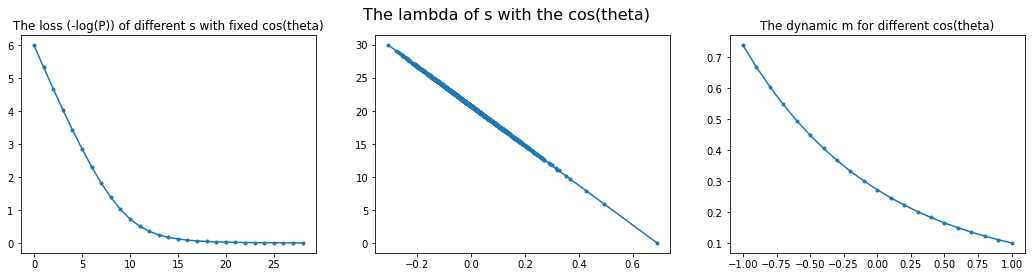

In [36]:
# plt.plot(sample_cos_sf)
plt.figure(figsize=(18, 4))
plt.suptitle('The lambda of s with the cos(theta)', fontsize=16)

ax1 = plt.subplot(131)
ax1.set_title('The loss (-log(P)) of different s with fixed cos(theta)')
log_pro = []
for s in range(1, 30):
    sample_cos_sf = -torch.log(torch.nn.functional.softmax(s*sample_cos, dim=0))
    log_pro.append(sample_cos_sf.min())

plt.plot(log_pro, marker='.')
# ax1.set_yscale('log')

ax2 = plt.subplot(132)
log_pro = []
s = 30
sample_cos_sf = -torch.log(torch.nn.functional.softmax(s*sample_cos, dim=0))
log_pro = sample_cos_sf.sort().values

plt.plot(sample_cos[sample_cos_sf.sort().indices], log_pro, marker='.')
# ax2.set_yscale('log')

ax3 = plt.subplot(133)
ax3.set_title('The dynamic m for different cos(theta)')

log_pro = []
x = np.arange(-10, 11)/10
y = 0.2*np.exp(1-x)/2

plt.plot(x, y, marker='.')

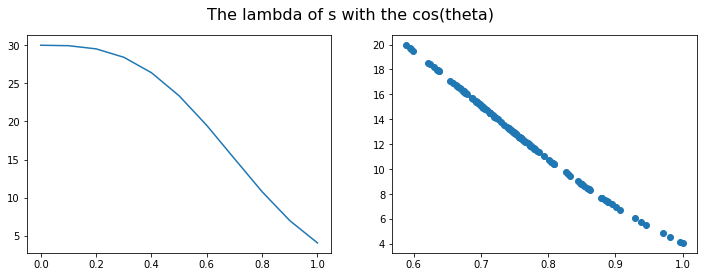

In [37]:
plt.figure(figsize=(12, 4))
plt.suptitle('The lambda of s with the cos(theta)', fontsize=16)

x = np.arange(0, 11)/10
y = 30*np.exp(-x*x*x*2)


ax1 = plt.subplot(121)
# ax1.set_title('The lambda of s with the cos(theta)')
plt.plot(x, y)

ax2 = plt.subplot(122)
# ax2.set_title('The lambda of s with the cos(theta)')

costh_m_s = torch.randn(128, 797)
costh_m_s /= costh_m_s.abs().max()

max_cos = costh_m_s.max(dim=1, keepdim=True).values
costh_m_s = costh_m_s * 1 / \
    (np.exp(max_cos*max_cos*max_cos*2))

plt.scatter(max_cos, 30 * 1 / (np.power(np.e, max_cos*max_cos*max_cos*2)))

In [34]:
# epochs = [i for i in range(1, 47)]
epoch = 46
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
spk2scores = {}
spk2nonscores = {}
spk2numofutts = {}

for s in spk2idx:
    spk2scores[s] = []
    spk2nonscores[s] = []
    
# target_dict = {}
xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix_nomean/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        g = key.split('-')[1]
        idx = spk2idx[spk]
        # print(idx)
        if spk in spk2numofutts:
            spk2numofutts[spk] += 1
        else:
            spk2numofutts[spk] = 1
            
        if len(numpy_array.shape) == 1:
            spk2scores[spk].append(numpy_array[idx])
            spk2nonscores[spk].extend(np.delete(numpy_array, idx))
        else:
            for n in numpy_array:
                spk2scores[spk].append(n[idx])
                spk2nonscores[spk].extend(np.delete(n, idx))

In [35]:
spk2stds = {}
numofutt2std = []
numofutts2angle = {}

for s in spk2scores:
    if len(spk2scores[s]) > 0:
        spk2stds[s] = np.std(spk2scores[s])
        numofutt2std.append([len(spk2scores[s]), np.std(spk2scores[s])])
    
        if spk2numofutts[s] in numofutts2angle:
            numofutts2angle[spk2numofutts[s]].extend(spk2scores[s])
        else:
            numofutts2angle[spk2numofutts[s]] = spk2scores[s]
        
numofutt2std = np.array(numofutt2std)
spk2numofg = {spk: len(spk2genres[spk]) for spk in spk2genres}

In [36]:
spk2angle = {spk: np.arccos(spk2scores[spk]) for spk in spk2scores}
spk2non_angle = {spk: np.arccos(spk2nonscores[spk]) for spk in spk2nonscores}

all_stats = []
for spk in spk2numofutts:
     all_stats.append([spk, spk2numofutts[spk], np.log(spk2num_frames[spk]*0.01), spk2angle[spk], spk2nonscores[spk], spk2numofg[spk]])
        
pd_all_stat = pd.DataFrame(all_stats, columns=['sid', 'numofutt', 'dur', 'angles', 'non_angles', 'numofg'])

In [37]:
numofg2angles = {}
numofg2non_angles = {}

for spk in spk2numofg:
    if spk2numofg[spk] not in numofg2angles:
        numofg2angles[spk2numofg[spk]] = []
    
    numofg2angles[spk2numofg[spk]].extend(spk2angle[spk]) 
    
    if spk2numofg[spk] not in numofg2non_angles:
        numofg2non_angles[spk2numofg[spk]] = []
    
    numofg2non_angles[spk2numofg[spk]].extend(spk2non_angle[spk]) 
    
numofg2ms = [[ i, np.mean(numofg2angles[i])*180/np.pi, np.std(numofg2angles[i])*180/np.pi,np.mean(numofg2non_angles[i])*180/np.pi, np.std(numofg2non_angles[i])*180/np.pi ] for i in numofg2angles]
pd_numofg2ms = pd.DataFrame(numofg2ms, columns=['numofgenres', 'mean', 'std', 'n_mean', 'n_std'])


<AxesSubplot:xlabel='numofgenres', ylabel='n_std'>

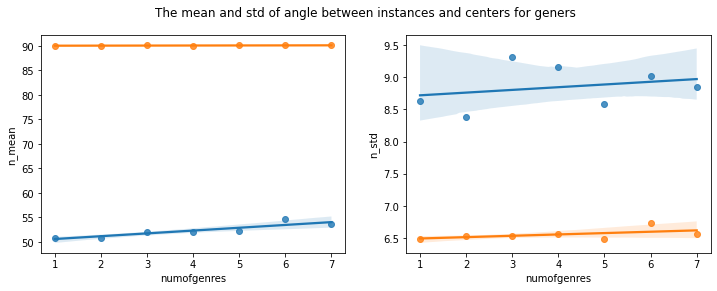

In [42]:
plt.figure(figsize=(12, 4))
plt.suptitle('The mean and std of angle between instances and centers for geners')

plt.subplot(121)
sns.regplot(x='numofgenres', y='mean', data=pd_numofg2ms)
sns.regplot(x='numofgenres', y='n_mean', data=pd_numofg2ms)

# plt.ylim(0.5, 1.0)

plt.subplot(122)
sns.regplot(x='numofgenres', y='std', data=pd_numofg2ms)
sns.regplot(x='numofgenres', y='n_std', data=pd_numofg2ms)
# sns.pairplot(data=pd_numofg2ms, x_vars=['numofg'], y_vars=['mean', 'std'])

<AxesSubplot:ylabel='Density'>

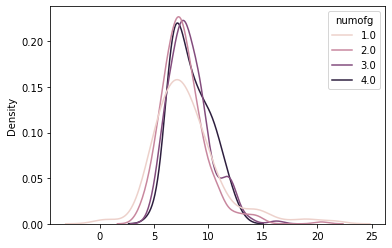

In [43]:
plt.figure(figsize=(6, 4))

# sns.scatterplot(pd_all_stat, x='dur', y=[ i.std()*180/np.pi for i in pd_all_stat['angles']], hue='numofg')
# sns.kdeplot(pd_all_stat.where(pd_all_stat['numofg']<5), x=[ i.mean()*180/np.pi for i in pd_all_stat['angles']], hue='numofg', common_norm=False)

# sns.scatterplot(pd_all_stat, x='numofg', y=[ i.mean()*180/np.pi for i in pd_all_stat['angles']],  s=50, linewidth=0.1, alpha=0.2)
sns.kdeplot(pd_all_stat.where(pd_all_stat['numofg']<5), x=[i.std()*180/np.pi for i in pd_all_stat['angles']], hue='numofg', common_norm=False)

In [44]:
numofutts2msa = []
for i in numofutts2angle:
    numofutts2msa.append([i, np.mean(numofutts2angle[i])*180/np.pi, np.std(numofutts2angle[i])*180/np.pi])
    
pd_numofutts2msa = pd.DataFrame(numofutts2msa, columns=['numofu', 'mean', 'std'])